## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

In [27]:
#impports and magics
import numpy as np
from scipy import linalg
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# local modules
import opg2py
from opg2py import ProfitClass
model = ProfitClass()

initializing the model
calling.setup()


You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

As statet in the problemset the profits are given by:
$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$
This can be simplified for the following for $\kappa=1$
$$
\Pi_t=\ell_t^{0.5}-\ell_t
$$
And for $\kappa=2$
$$
\Pi_t=2\ell_t^{0.5}-\ell_t
$$

We see that when $\kappa=1$ we have the following value for $\ell_t$:

$$
\ell_t=\left(\frac{(1-0.5)*1}{1}\right)^{\frac{1}{0.5}}
\\
\ell_t=\left(\frac{0.5}{1}\right)^{\frac{1}{0.5}}=0.25
$$

We see that when $\kappa=2$ we have the following value for $\ell_t$:
$$
\ell_t=\left(\frac{(1-0.5)*2}{1}\right)^{\frac{1}{0.5}}
\\
\ell_t=\left(\frac{1}{1}\right)^{\frac{1}{0.5}}
\\
\ell_t=1^2=1
$$

We also make python solve this numiricly in the py.file by using sympy 

In [31]:
model = ProfitClass(do_print=False)
model.solve_numerical_kappa1()

Optimal ell_t value for kappa = 1.0: 0.250000000000000


In [2]:
model = ProfitClass(do_print=False)
model.solve_numerical_kappa2()

Optimal ell_t value for kappa = 2.0: 1.00000000000000


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$

The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [2]:
model = ProfitClass(do_print=False)
model.Calculate_H()

Expected value of the salon (H): 27.55268350881889


We chose the value of K = 1000 as it strikes a balance between computational efficiency and estimation accuracy. This value allows us to obtain a reasonably accurate estimate of the expected value of the salon (H) while keeping the computational resources and time required within manageable limits.

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.


**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [3]:
model = ProfitClass(do_print=False)
model.calculate_H_Delta()

Expected value of the salon (H): 28.5471990797166


By optimizing the number of hairdressers with the small variation in the form of $\Delta=0.05$ this leads to an increase in the profitability. The expected value of the salon (H) improves from 27.71 to 28.25. By adjusting the number of hairdressers in response to demand fluctuations, the salon maximizes revenue and minimizes costs, resulting in enhanced profitability.

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

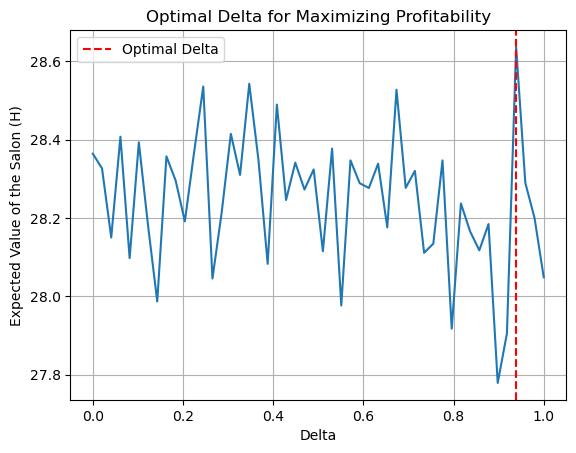

Optimal Delta: 0.9387755102040816
Maximum Expected value of the salon (H): 28.636144026031314


In [26]:
model = ProfitClass(do_print=False)
model.Maximize_H_Delta()

Vi skal illustrere dette


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.

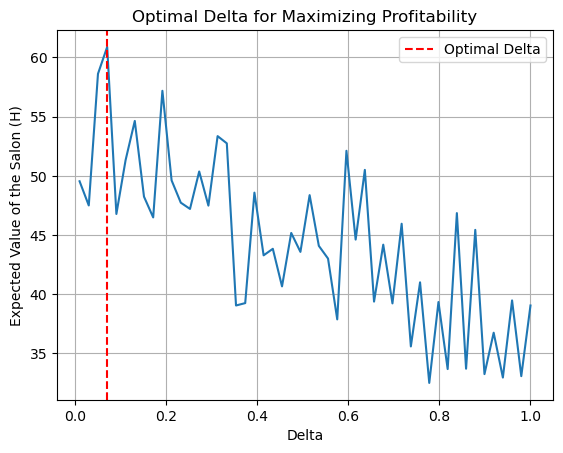

Optimal Delta: 0.07061224489795918
Maximum Expected Value of the Salon (H): 60.89288835996103


In [32]:
model = ProfitClass(do_print=False)
model.Maximize_H_Delta_test()